<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/09_Skimlit_NLP_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: Skimlit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is availabel here: https://arxiv.org/abs/1612.05251

**Resource:** If we want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


## Confirm access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-da384333-34d6-1bc6-eab8-9c7312d518be)


## Getting the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authords Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Becoming one with the data

In [5]:
# Start our experiments using the 20k dataset with numbers replaced by the '@' sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

So, with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filenames.
  """
  with open(filename, mode="r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines= get_lines(filenames[0]) # read the lines within the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number':0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines': 11},
   ...]
```

In [10]:
# Creating a function to convert text into dictionaries
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Args:
    filename: Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence, how many
    sentences are in the current abstract and what sentence number the target
    line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line 
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
    
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line apper in the abstract
        line_data["total line"] = len(abstract_line_split)-1 # how many total lines are there in the target abstract?  (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[2])
print(len(train_samples), len(val_samples), len(test_samples))

180040 30135 30212
CPU times: user 558 ms, sys: 98.5 ms, total: 656 ms
Wall time: 659 ms


In [12]:
# Check the first abstract of the training data
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total line': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total line': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total line': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total line': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included th

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head(15)

,target,text,line_number,total line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Check the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

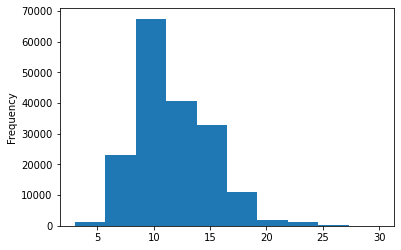

In [16]:
# Check the length of different lines
train_df["total line"].plot.hist();

## Get list of sentences

In [17]:
# Getting a list of sentences from Dataframes
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30135, 30212)

In [18]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [19]:
# One hot encode labels for using Categorical Cross Entropy
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(X=train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(X=val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(X=test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded label look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
train_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [21]:
train_df["target"].to_numpy().reshape(-1,1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

## Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [24]:
# Get class names and number of classes from one hot encoder instance
nc = len(one_hot_encoder.categories_[0])
cn = one_hot_encoder.categories_
nc,cn

(5, [array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
        dtype=object)])

In [25]:
class_names == cn

array([[ True,  True,  True,  True,  True]])

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline (TF_IDF Multinomial Naive Bayes Classifier)

1. Model_0: Naive Bayes with TF-IDF encoder (baseline)
2. Model_1: Conv1D with token embeddings
3. Model_2: TensorFlow Hub Pretrained Feature Extractor
4. Model_3: Conv_1D with character embeddings
5. Model_4: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
6. Model_5: Pretrained token embeddings + character embeddings + positional embeddings

## Model 0: Baseline model (Term Frequency — Inverse Document Frequency)

For more knowledge on TF-IDF see: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
model_0.score(val_sentences, val_labels_encoded)

0.716674962667994

In [28]:
# Make predictions with the baseline model
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([2, 2, 2, ..., 4, 4, 4])

In [29]:
# Check val labels
val_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [30]:
# Make predictions and return results using our baseline model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  results = {}
  acc_score = accuracy_score(y_true,y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  results["accuracy"] = acc_score*100
  results["precision"] = model_precision
  results["recall"] = model_recall
  results["f1-score"] = model_f1
  return results

In [31]:
# Check baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_0_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'f1-score': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

## Tokenization

In [32]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [33]:
# How long is each sentence on an average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences] # counts each word in separate lines
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

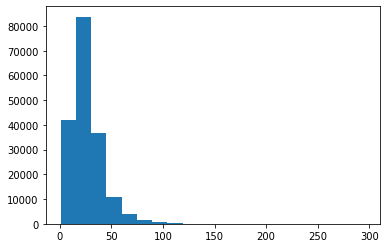

In [34]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [35]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len # around 95% of the sentences are under 55 tokens in length

55

In [36]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [37]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 68000 # taken from paper
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True)

In [38]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [39]:
# Test out text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}\n\nLength of text: {len(random_sentence.split())} \n\nText Vectorizer output:\n {text_vectorizer([random_sentence])}")

Text:
statistically significant reductions in all sensitivity variables were achieved by day @ and even greater reductions in dentin sensitivity scores were observed after five days .

Length of text: 26 

Text Vectorizer output:
 [[ 232   37  626    5   62  509  498    9  454   22  108    3  983  182
   626    5 3631  509  119    9  148   21  487   84    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [40]:
# How many words in vocabulary, most common words, most least common words?
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"Total words in vocabulary: {len(words_in_vocab)}\n10 Most common words: {words_in_vocab[:10]}\n10 Most Least Common Words: {words_in_vocab[-10:]}")

Total words in vocabulary: 64841
10 Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 Most Least Common Words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [42]:
# Create token embedding layer (feature-vector matrix representation)
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence length (save space)
                               input_length=output_seq_len,
                               name="token_embedding")

In [43]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedding_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedding_sentence}\n")
print(f"Embedded sentence shape: {embedding_sentence.shape}")

Sentence before vectorization:
 statistically significant reductions in all sensitivity variables were achieved by day @ and even greater reductions in dentin sensitivity scores were observed after five days .

Sentence after vectorization (before embedding):
 [[ 232   37  626    5   62  509  498    9  454   22  108    3  983  182
   626    5 3631  509  119    9  148   21  487   84    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01042878 -0.04669868  0.01873044 ...  0.0195548   0.00187219
   -0.03291046]
  [ 0.0105731   0.03844078  0.0350921  ... -0.01657807 -0.02088611
    0.03756632]
  [-0.03076108  0.01082043 -0.03024212 ... -0.01280931  0.03256483
    0.03028632]
  ...
  [ 0.04542929 -0.0389912   0.03946277 ...  0.0286091   0.03997398
   -0.01537623]
  [ 0.04542929 -0.0389912   0.03946277 ...  0.0286091   0.03997398
   -0.01537623]
  [ 0

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discusses at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [44]:
# Turn our data into TensorFlow datasets (passing one_hot_encoded labels)
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [45]:
# Take the TensorSlice Datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model_1: Conv1D with token embeddings

In [46]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string,name='input_layer')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="same",
                  activation="relu") (x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax",name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs,name='Conv1D')

In [47]:
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
__________________________________________________

In [48]:
# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [49]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(len(train_dataset)*0.1),
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)*0.1))

Epoch 1/3
562/562 [==============================] - 37s 14ms/step - loss: 0.8352 - accuracy: 0.6786 - val_loss: 0.6045 - val_accuracy: 0.7766
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.5791 - accuracy: 0.7871 - val_loss: 0.5491 - val_accuracy: 0.8002
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.5434 - accuracy: 0.8017 - val_loss: 0.5262 - val_accuracy: 0.8009


In [50]:
# Evaluate on whole valid dataset
model_1.evaluate(valid_dataset)

942/942 [==============================] - 4s 5ms/step - loss: 0.5382 - accuracy: 0.7996


[0.5381796360015869, 0.7996017932891846]

In [51]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs= model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[2.9904675e-01, 2.4283528e-01, 1.7592077e-01, 2.2485219e-01,
         5.7345022e-02],
        [1.3707422e-02, 1.0982752e-02, 9.0553927e-01, 9.3870591e-03,
         6.0383502e-02],
        [1.6685546e-04, 9.4222609e-04, 8.6620885e-01, 6.5022221e-05,
         1.3261700e-01],
        ...,
        [1.2006397e-04, 1.3441342e-02, 4.1191368e-03, 7.4740630e-05,
         9.8224479e-01],
        [8.8182284e-04, 6.9309529e-03, 1.5763287e-02, 2.7584549e-04,
         9.7614813e-01],
        [8.3423695e-03, 6.6191679e-01, 1.1334047e-01, 8.1914123e-03,
         2.0820884e-01]], dtype=float32), (30135, 5))

In [52]:
# Convert pred probs to classes
model_1_preds = model_1_pred_probs.argmax(axis=1)
model_1_preds

array([0, 2, 2, ..., 4, 4, 1])

In [53]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.96017919362866,
 'f1-score': 0.7979444681426064,
 'precision': 0.7981405040221042,
 'recall': 0.7996017919362867}

## Model 2: Feature Extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder:
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally use GloVe embeddings, however, we're going to stick with the later created `USE` pretrained embeddings.

### Model_2: USE (Universal Sentence Encoder)

In [54]:
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [55]:
# Download pretrained TensorFlow Hub USE
hub_embedding_layer = hub.KerasLayer(USE_URL,
                                     trainable=False,
                                     name="universal_sentence_encoder")

In [56]:
# Test out the pretrained embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_sentence}\n")
use_embedding_sentence = hub_embedding_layer([random_sentence])
print(f"Sentence after embedding:\n {use_embedding_sentence}\n")
print(f"Shape of sentence embedding: {use_embedding_sentence.shape}")

Random sentence:
 the total dopamine dose used was recorded at the end of surgery , and blood samples were collected at t@ and at @ h ( t@ ) and @ h ( t@ ) after the operation for determination of serum levels of ctn , ck-mb and bnp .

Sentence after embedding:
 [[-0.05001812 -0.05979447  0.00633094 -0.01316445 -0.00801793 -0.00158271
   0.00530569  0.02383522  0.01149386 -0.01181736  0.08083793  0.02282673
  -0.04897487  0.05389332  0.01559272 -0.04011433 -0.07615978  0.05303442
  -0.04297933  0.06118561 -0.03766623  0.04653416 -0.05951991  0.02819518
  -0.06923614  0.05425349  0.05193557 -0.01334887 -0.02862945 -0.03770152
   0.05913578  0.08280765  0.02415737 -0.00961736  0.02715215  0.00841906
  -0.05559886 -0.0539947  -0.02754316  0.0072785  -0.04231916  0.04329758
  -0.01007933 -0.04364223  0.02575274  0.05798757  0.02824965  0.05214237
  -0.04150791  0.02294604 -0.04763351  0.03175782 -0.06814595  0.03522058
  -0.01216986  0.0314922  -0.0620885  -0.04441432  0.03177683 -0.076703

### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub


In [57]:
inputs = layers.Input(shape=[],dtype=tf.string,name="input_layer")
pretrained_embedding = hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
# Note: we could add more layers if we wanted to
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [58]:
# Get the summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [59]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9174 - accuracy: 0.6489 - val_loss: 0.8326 - val_accuracy: 0.6862
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7681 - accuracy: 0.7033 - val_loss: 0.7782 - val_accuracy: 0.6968
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7509 - accuracy: 0.7129 - val_loss: 0.7567 - val_accuracy: 0.7048


In [60]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

942/942 [==============================] - 15s 16ms/step - loss: 0.7545 - accuracy: 0.7081


[0.7545276880264282, 0.7081134915351868]

In [61]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

(array([[3.3623758e-01, 9.8644577e-02, 3.9836612e-02, 4.8981816e-01,
         3.5463147e-02],
        [2.5968000e-01, 4.6333916e-02, 9.1411076e-02, 5.8387905e-01,
         1.8695960e-02],
        [1.2296309e-03, 8.1446469e-03, 8.5394418e-01, 1.6703294e-03,
         1.3501126e-01],
        ...,
        [4.5303209e-04, 2.1145929e-02, 1.6214892e-02, 1.2160276e-04,
         9.6206450e-01],
        [1.0922081e-02, 5.0151810e-02, 7.4847497e-02, 2.2812414e-03,
         8.6179739e-01],
        [1.4148994e-02, 6.4361501e-01, 1.4926991e-01, 1.3684318e-02,
         1.7928183e-01]], dtype=float32), (30135, 5))

In [62]:
# Convert pred_probs to classes
model_2_preds = model_2_pred_probs.argmax(axis=1)
model_2_preds

array([3, 3, 2, ..., 4, 4, 1])

In [63]:
# Getting the model 2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 70.81134892981584,
 'f1-score': 0.705221474536667,
 'precision': 0.7105268809128306,
 'recall': 0.7081134892981583}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previosuly, we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.



### Creating a character level tokenizer

In [64]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [65]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [66]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_sentence)

't h e   t o t a l   d o p a m i n e   d o s e   u s e d   w a s   r e c o r d e d   a t   t h e   e n d   o f   s u r g e r y   ,   a n d   b l o o d   s a m p l e s   w e r e   c o l l e c t e d   a t   t @   a n d   a t   @   h   (   t @   )   a n d   @   h   (   t @   )   a f t e r   t h e   o p e r a t i o n   f o r   d e t e r m i n a t i o n   o f   s e r u m   l e v e l s   o f   c t n   ,   c k - m b   a n d   b n p   .'

In [67]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [68]:
# What's the average character length?
char_length = [len(sentence) for sentence in train_sentences] # counts lenght of all characters in a single sequence
avg_char_length = np.mean(char_length)
avg_char_length

149.3662574983337

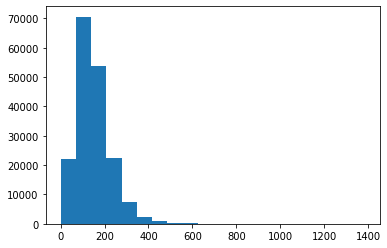

In [69]:
# Check the distribution of our sequences at a character-level
plt.hist(char_length,bins=20);

In [70]:
# What lenght of character covers 95% of sequences in character-level sequences
output_seq_char_len = int(np.percentile(char_length,95))
output_seq_char_len

290

In [71]:
# Get all keyboard characters
import string
aplhabet = string.ascii_lowercase + string.digits + string.punctuation
aplhabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create char-level token vectorizer instance
NUM_CHARS_TOKENS = len(aplhabet) + 2 # add 2 for space and <OOV> token (out of vocab ='[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    pad_to_max_tokens=True,
                                    name="char_vectorizer")

In [73]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [74]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most Common Characters: {char_vocab[:5]}")
print(f"5 Most Least Common Characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most Common Characters: ['', '[UNK]', 'e', 't', 'i']
5 Most Least Common Characters: ['k', 'x', 'z', 'q', 'j']


In [75]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized text:\n {vectorized_chars}")
print(f"\nShape of Vectorized text: {vectorized_chars.shape}")

Charified text:
 b a s e d   o n   p a t h o l o g i c a l   ,   m a g n e t i c   r e s o n a n c e   i m a g i n g   (   m r i   )   a n d   a r t h r o s c o p y   s t u d i e s   ,   p r o g r e s s i v e   o s t e o a r t h r i t i s   i n v o l v e s   a l l   t i s s u e s   o f   t h e   j o i n t   a n d   i n c l u d e s   b o n e   m a r r o w   l e s i o n s   ,   s y n o v i a l   p r o l i f e r a t i o n   ,   f a t   p a d   i n f l a m m a t i o n   ,   a n d   h i g h   s u b c h o n d r a l   b o n e   t u r n o v e r   .

Length of random_train_chars: 225

Vectorized text:
 [[22  5  9  2 10  7  6 14  5  3 13  7 12  7 18  4 11  5 12 15  5 18  6  2
   3  4 11  8  2  9  7  6  5  6 11  2  4 15  5 18  4  6 18 15  8  4  5  6
  10  5  8  3 13  8  7  9 11  7 14 19  9  3 16 10  4  2  9 14  8  7 18  8
   2  9  9  4 21  2  7  9  3  2  7  5  8  3 13  8  4  3  4  9  4  6 21  7
  12 21  2  9  5 12 12  3  4  9  9 16  2  9  7 17  3 13  2 27  7  4  6  3
   5  6 10  4  6 11 12 16 10 

### Character level embedding

In [76]:
from tensorflow.keras import layers
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters 
                              output_dim=25, # size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embedding")

In [77]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization & embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 b a s e d   o n   p a t h o l o g i c a l   ,   m a g n e t i c   r e s o n a n c e   i m a g i n g   (   m r i   )   a n d   a r t h r o s c o p y   s t u d i e s   ,   p r o g r e s s i v e   o s t e o a r t h r i t i s   i n v o l v e s   a l l   t i s s u e s   o f   t h e   j o i n t   a n d   i n c l u d e s   b o n e   m a r r o w   l e s i o n s   ,   s y n o v i a l   p r o l i f e r a t i o n   ,   f a t   p a d   i n f l a m m a t i o n   ,   a n d   h i g h   s u b c h o n d r a l   b o n e   t u r n o v e r   .

Embedded chars (after vectorization & embedding):
 [[[ 0.0189968  -0.04344093 -0.03672215 ... -0.03619282  0.01435885
    0.04689361]
  [-0.01904505 -0.01742045  0.0307265  ... -0.01832183 -0.04049382
    0.04299146]
  [-0.00050961  0.0384462   0.0343365  ...  0.01527592  0.00039315
    0.01684508]
  ...
  [ 0.02157942  0.04298513 -0.04806218 ... -0.04224681 -0.00786533
    0.02657498]
  [ 0.02157942  0.04298513 -0.04806218 ... -0.04224681 -0.00786

### Building a Conv1D model to fit on character embeddings

In [78]:
# Make Conv1D on chars only
inputs = layers.Input(shape=[],dtype=tf.string,name="input_layer")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="same",
                  activation="relu") (x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_conv1D_char_emnbeddings")

# Compile
model_3.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [79]:
# Get the summary
model_3.summary()

Model: "model_3_conv1D_char_emnbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________

In [80]:
# Creating the character-level dataset
char_train_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_valid_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_test_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

char_train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [81]:
# Fit the model
history_model_3 = model_3.fit(char_train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(char_train_dataset)),
                              validation_data=char_valid_dataset,
                              validation_steps=int(0.1*len(char_valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2775 - accuracy: 0.4791 - val_loss: 1.0485 - val_accuracy: 0.5934
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0005 - accuracy: 0.5988 - val_loss: 0.9605 - val_accuracy: 0.6213
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9252 - accuracy: 0.6346 - val_loss: 0.8876 - val_accuracy: 0.6503


In [82]:
# Evaluate on the whole dataset
model_3.evaluate(char_valid_dataset)

942/942 [==============================] - 5s 5ms/step - loss: 0.8954 - accuracy: 0.6521


[0.8953855037689209, 0.6520988941192627]

In [83]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(char_valid_dataset)
model_3_pred_probs

array([[0.26296708, 0.23888879, 0.1831215 , 0.2942689 , 0.02075378],
       [0.06560296, 0.09555075, 0.67423505, 0.05476434, 0.10984685],
       [0.00100033, 0.00161428, 0.7859934 , 0.00104022, 0.21035177],
       ...,
       [0.00340042, 0.02245114, 0.02065455, 0.00280644, 0.9506875 ],
       [0.01536035, 0.05711909, 0.44960207, 0.01567948, 0.462239  ],
       [0.16595316, 0.35618854, 0.15814222, 0.14543472, 0.17428139]],
      dtype=float32)

In [84]:
# Convert prediction probs to class labels
model_3_preds = model_3_pred_probs.argmax(axis=1)
model_3_preds

array([3, 2, 2, ..., 4, 4, 1])

In [85]:
# Model_3_results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.20988883358221,
 'f1-score': 0.6422218225994883,
 'precision': 0.6500748551955084,
 'recall': 0.6520988883358221}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_2`)
2. Create a character-level embedding model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [86]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu") (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=[],dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layer=layers.LSTM(units=24))(char_embeddings) # bi-LSTM as per paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(rate=0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [87]:
# Get the summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

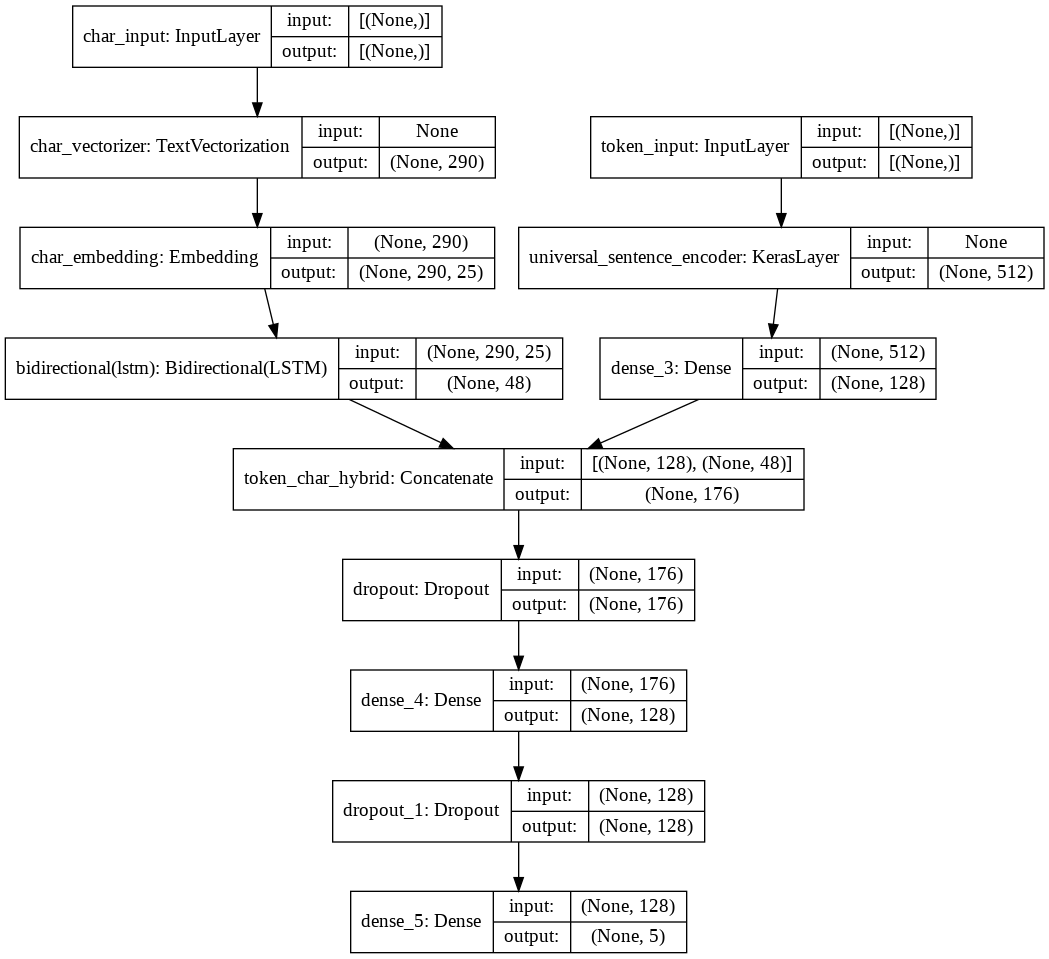

In [88]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [89]:
# Compile token char model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Combining token and character data into a tf.data Datset

In [90]:
# 1. Combine chars and tokens into a Dataset for training data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) # combine data and labels
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. Combine chars and tokens into a Dataset for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Combine chars and tokens into a Dataset for testing data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))
# Prefetch and batch validation data
test_char_token_dataset = test_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [91]:
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [92]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 82s 130ms/step - loss: 0.9855 - accuracy: 0.6122 - val_loss: 0.8156 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 70s 124ms/step - loss: 0.7994 - accuracy: 0.6920 - val_loss: 0.7417 - val_accuracy: 0.7118
Epoch 3/3
562/562 [==============================] - 67s 118ms/step - loss: 0.7754 - accuracy: 0.7041 - val_loss: 0.7125 - val_accuracy: 0.7241


In [93]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

942/942 [==============================] - 48s 51ms/step - loss: 0.7118 - accuracy: 0.7259


[0.7118285894393921, 0.7259001135826111]

In [94]:
# Make predictions using the token-character hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.12052995e-01, 1.64817482e-01, 7.56114870e-02, 4.06992853e-01,
        4.05251980e-02],
       [2.55677283e-01, 5.56265339e-02, 1.71633750e-01, 4.99781936e-01,
        1.72804482e-02],
       [1.01515336e-03, 4.44093114e-03, 8.50048900e-01, 6.14062068e-04,
        1.43880948e-01],
       ...,
       [4.19355347e-04, 3.14771123e-02, 2.65951883e-02, 1.07359199e-04,
        9.41401005e-01],
       [3.24594835e-03, 5.40936664e-02, 8.85128975e-02, 2.47070659e-03,
        8.51676762e-01],
       [3.05548348e-02, 6.44782364e-01, 1.06248766e-01, 1.91140175e-02,
        1.99300021e-01]], dtype=float32)

In [95]:
# Format pred probs into pred labels
model_4_preds = model_4_pred_probs.argmax(axis=1)
model_4_preds

array([3, 3, 2, ..., 4, 4, 1])

In [96]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.59001161440186,
 'f1-score': 0.7227367287686486,
 'precision': 0.7260492362826476,
 'recall': 0.7259001161440186}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [97]:
train_df.head()

,target,text,line_number,total line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> Any engineered features used to train a model need to be availabe at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [98]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

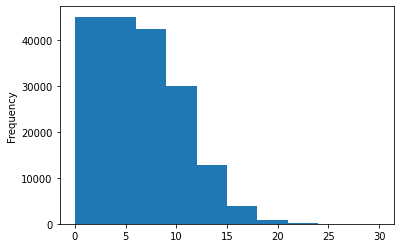

In [99]:
# Check the distribution of line_number column
train_df.line_number.plot.hist();

In [104]:
# Use tensorflow to create one_hot_encoded tensors of our line_number columns
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line number feature, let's do the same for our total line features

In [107]:
# How many different number of lines are there?
train_df["total line"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total line, dtype: int64

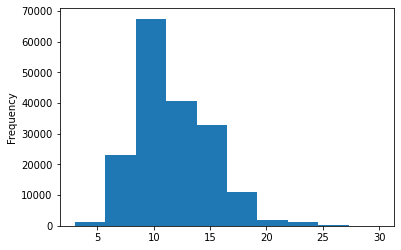

In [108]:
# Check the distribution of total line column
train_df["total line"].plot.hist();

In [110]:
# Check the 95% coverage of a total lines?
np.percentile(train_df["total line"],95)

18.0

In [112]:
# Use TensorFlow to create one hot encoded tensors of our total line feature
train_total_lines_one_hot = tf.one_hot(train_df["total line"].to_numpy(),depth=18)
val_total_lines_one_hot = tf.one_hot(val_df["total line"].to_numpy(),depth=18)
test_total_lines_one_hot = tf.one_hot(test_df["total line"].to_numpy(),depth=18)
train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and the outputs of 7 into a tf.keras.Model

In [117]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_layer")
token_embeddings = hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ),dtype=tf.string,name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layer=layers.LSTM(units=24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line Number feature model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_input")
line_number_dense = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

# 4. Total Line Feature model
total_lines_inputs = layers.Input(shape=(18,),dtype=tf.float32,name="total_lines_input")
total_lines_dense = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_dense)

# 5. Combine outputs of model 1 & 2
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_model")([token_model.output,
                                                                                   char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(rate=0.5)(z)

# 6. Combine outputs of model 3,4,5
tribrid_embeddings = tf.keras.layers.Concatenate(name="token_char_positional_tribrid_model")([line_number_model.output,
                                                                                              total_lines_model.output,
                                                                                              z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="Softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_model")

In [118]:
# Get the summary
model_5.summary()

Model: "tribrid_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_layer (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_layer[0][0]                
______________________________________________________________________________________

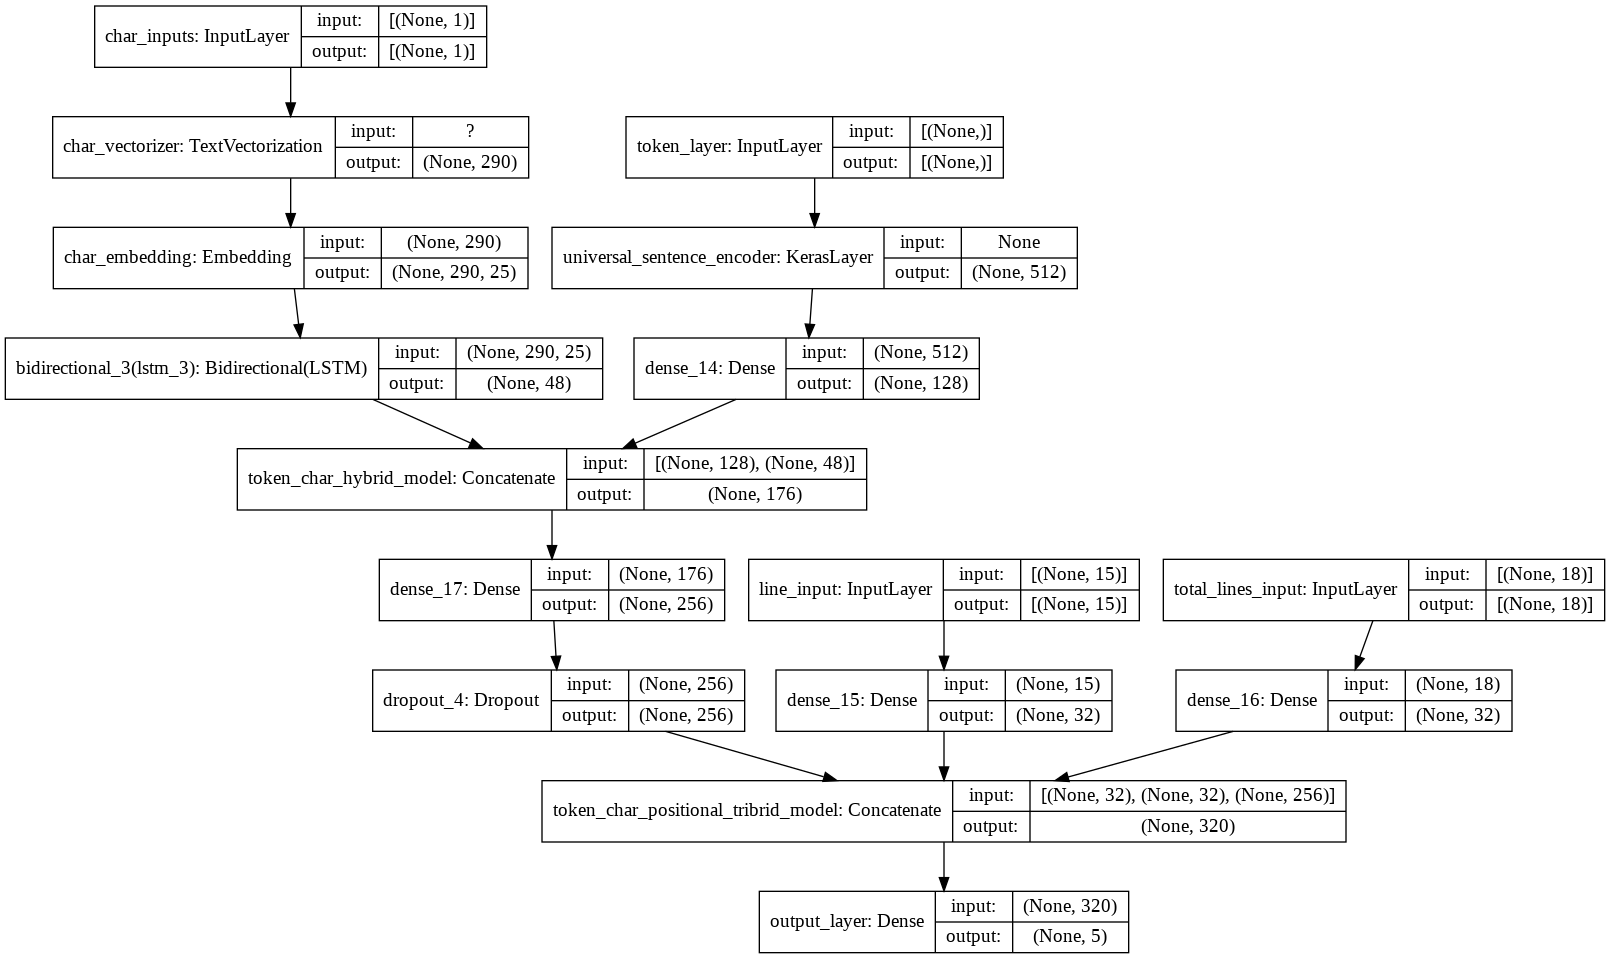

In [119]:
# Plot model 5
plot_model(model_5,show_shapes=True)

What is Label Smoothing?

For example if our model gets too confident on a single class (e.g. its prediction probabiliy is really high), it may get stuck on that class and not consider other classes.

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred probs to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> More info on Label Smoothing from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [120]:
# Compile the model
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent over-fitting
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

###  Creating tribrid embeddings datasets

In [121]:
# 1. Training dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_tribrid_dataset = train_char_token_pos_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_tribrid_dataset = val_char_token_pos_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# # 3. Testing dataset
# test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
#                                                                test_total_lines_one_hot,
#                                                                test_sentences,
#                                                                test_chars))
# test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
# test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
# test_tribrid_dataset = test_char_token_pos_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [122]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 18), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 18), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with the tribrid model

In [124]:
# Fit the model
history_model_5 = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 130ms/step - loss: 1.0966 - accuracy: 0.7244 - val_loss: 0.9964 - val_accuracy: 0.7912
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.9677 - accuracy: 0.8157 - val_loss: 0.9633 - val_accuracy: 0.8148
Epoch 3/3
562/562 [==============================] - 67s 120ms/step - loss: 0.9491 - accuracy: 0.8240 - val_loss: 0.9485 - val_accuracy: 0.8261


In [125]:
# Evaluate on the whole model
model_5.evaluate(val_tribrid_dataset)

942/942 [==============================] - 48s 51ms/step - loss: 0.9446 - accuracy: 0.8279


[0.9446299076080322, 0.8279077410697937]

In [126]:
# Making predictions
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

array([[0.3602036 , 0.07979205, 0.03342903, 0.48694143, 0.03963395],
       [0.34472907, 0.06604493, 0.23171322, 0.32286906, 0.03464375],
       [0.07379283, 0.02621033, 0.745898  , 0.10152958, 0.05256922],
       ...,
       [0.08489351, 0.08977435, 0.08100989, 0.06173234, 0.6825899 ],
       [0.07003067, 0.07535953, 0.08703957, 0.05771663, 0.7098536 ],
       [0.0899968 , 0.52193224, 0.15492795, 0.05841527, 0.17472775]],
      dtype=float32)

In [127]:
# Convert pred probs to classes
model_5_preds = model_5_pred_probs.argmax(axis=1)
model_5_preds

array([3, 0, 2, ..., 4, 4, 1])

In [129]:
# Calculate the results of models 5
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.79077484652397,
 'f1-score': 0.8267062317614597,
 'precision': 0.8266423343018995,
 'recall': 0.8279077484652397}

In [130]:
model_4_results

{'accuracy': 72.59001161440186,
 'f1-score': 0.7227367287686486,
 'precision': 0.7260492362826476,
 'recall': 0.7259001161440186}

## Comparing the models

In [133]:
all_model_results = pd.DataFrame({
    "Baseline Model": baseline_results,
    "Conv1D with custom token embeddings": model_1_results,
    "Pretrained TF Hub Model": model_2_results,
    "Conv1D with char embeddings": model_3_results,
    "Combined token & char embeddings": model_4_results,
    "Combined token, char & positional embeddings":model_5_results
})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1-score
Baseline Model,71.667496,0.712432,0.716675,0.692510
Conv1D with custom token embeddings,79.960179,0.798141,0.799602,0.797944
Pretrained TF Hub Model,70.811349,0.710527,0.708113,0.705221
Conv1D with char embeddings,65.209889,0.650075,0.652099,0.642222
Combined token & char embeddings,72.590012,0.726049,0.725900,0.722737
"Combined token, char & positional embeddings",82.790775,0.826642,0.827908,0.826706


In [135]:
# Scaling at the same level
all_model_results["accuracy"] = all_model_results.accuracy/100

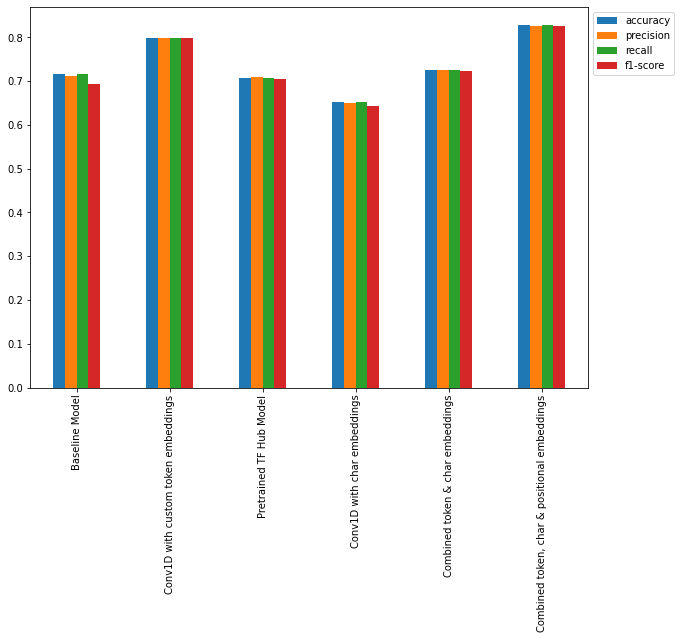

In [139]:
# Plot all model results 
all_model_results.plot.bar(figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

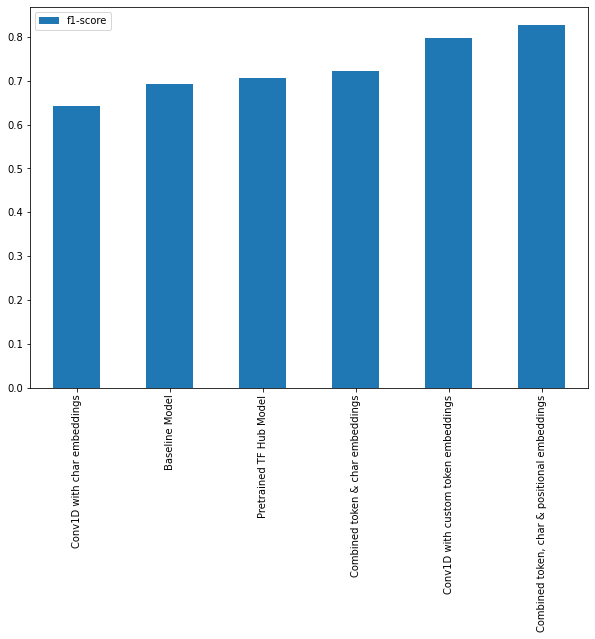

In [145]:
# Plotting f1-scores of all models
all_model_results.sort_values(by="f1-score")["f1-score"].plot.bar(figsize=(10,7)).legend();